In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [20]:
df = pd.read_csv('dataset/marketing_campaign.csv', sep=';')
df.shape

(2240, 29)

In [21]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [22]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [23]:
print(df.Z_CostContact.describe())
print(df.Z_Revenue.describe())

count    2240.0
mean        3.0
std         0.0
min         3.0
25%         3.0
50%         3.0
75%         3.0
max         3.0
Name: Z_CostContact, dtype: float64
count    2240.0
mean       11.0
std         0.0
min        11.0
25%        11.0
50%        11.0
75%        11.0
max        11.0
Name: Z_Revenue, dtype: float64


**Z_CostContact** and **Z_Revenue** seem to be constants which won't affect our analysis or algorithms, so we can drop these columns.

In [24]:
df = df.drop(['Z_Revenue', 'Z_CostContact'], axis=1)

In [25]:
df['Kidhome'].value_counts()

0    1293
1     899
2      48
Name: Kidhome, dtype: int64

In [26]:
df['Teenhome'].value_counts()

0    1158
1    1030
2      52
Name: Teenhome, dtype: int64

The number of kids at home and teens at home can be combined into a single column.

In [27]:
df['Minorhome'] = df.Kidhome + df.Teenhome
df = df.drop(['Kidhome', 'Teenhome'], axis=1)
# print(df.info())

In [28]:
df['Minorhome'].value_counts()

1    1128
0     638
2     421
3      53
Name: Minorhome, dtype: int64

<AxesSubplot:>

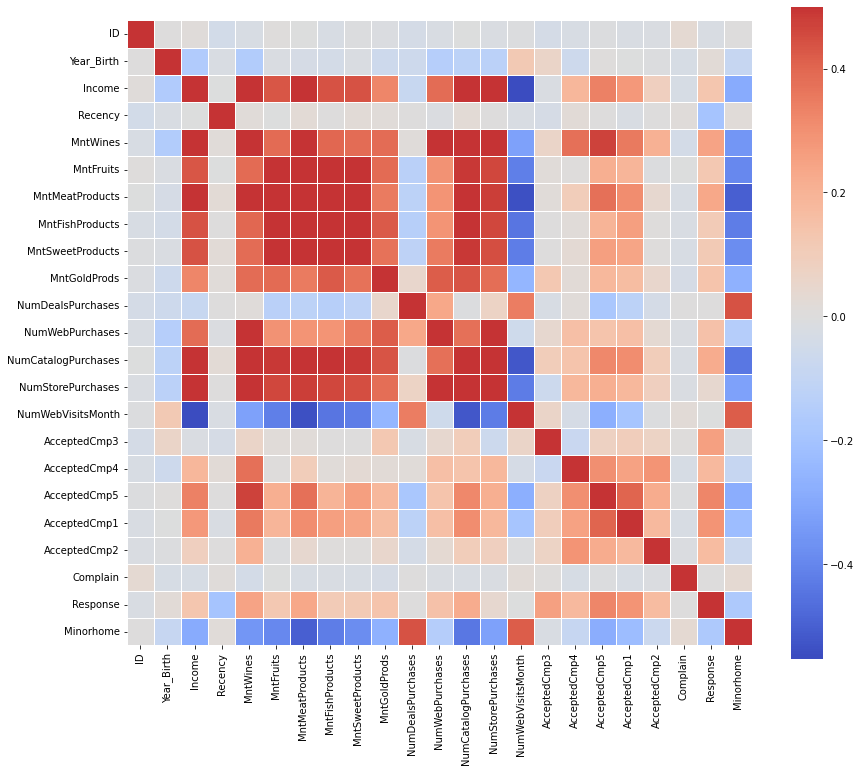

In [29]:
correlation = df.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation, center=0, vmax=0.5, square=True, linewidths=1, cmap='coolwarm')
# plt.show()
# df.corr()['Response'].sort_values(ascending=False)

In [30]:
df.Dt_Customer.describe()

count           2240
unique           663
top       2012-08-31
freq              12
Name: Dt_Customer, dtype: object

In [31]:
df.Year_Birth.describe()

count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64

We can extract more useful features from these two columns and strip away the superfluous information.
- `year` and `month` from `Dt_Customer`
- `Age` from `(Dt_Customer - Year_Birth)`

In [32]:
year = pd.to_numeric(df['Dt_Customer'].str.extract(r'(\d{4})', expand=False))
month = pd.to_numeric(df['Dt_Customer'].str.extract(r'-(\d{2})-', expand=False))

In [34]:
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month = month.value_counts().reset_index().sort_values('index')
month = month.replace(month_names)
month = month.rename(columns={'index': 'Month', 'Dt_Customer': 'Enrolments'})
print(month)

   Month  Enrolments
4    Jan         197
8    Feb         178
3    Mar         211
7    Apr         182
1    May         216
10   Jun         166
11   Jul         101
0    Aug         222
5    Sep         193
2    Oct         212
6    Nov         187
9    Dec         175


In [35]:
is_high = month['Enrolments'] > 200
color_sequence = is_high.apply(lambda x: 'crimson' if x else 'rgb(55, 83, 109)')
color_sequence = color_sequence.tolist()

fig = px.bar(month, x='Month', y='Enrolments', title='Customer Enrolments by Month', color='Month', color_discrete_sequence=color_sequence)
fig.layout.update(showlegend=False)
fig.show()

This chart could have been much more powerful if we had data on the months in which the last few campaigns were active, so it would have been possible to measure impact.</br>
Without this information and with our current visualization, there seem to be no stand-out months which could boost the response.</br>
However, it seems as if July should be excluded from the campaign period.

In [36]:
df['Age'] = year - df['Year_Birth']
df = df.drop(['Year_Birth'], axis=1)
# print(df['Age'].head())

In [37]:
df.Age.describe()

count    2240.000000
mean       44.222321
std        12.022855
min        16.000000
25%        36.000000
50%        43.000000
75%        54.000000
max       121.000000
Name: Age, dtype: float64

In [38]:
df.Age.sort_values(ascending=False)

239     121
339     114
192     113
1950     73
424      72
       ... 
914      18
1163     18
2213     17
1850     17
46       16
Name: Age, Length: 2240, dtype: int64

The **Age** column has a few entries over 100 years. This is highly unlikely and possibly an error. We can eliminate these entries.

In [39]:
df = df[df['Age'] < 100]

**Age** makes more sense as a *categorical* variable than a *continuous* variable so we can group users together.

In [47]:
bins = [0, 30, 40, 50, 65, np.inf]
labels = ['<30', '30-40', '40-50', '50-65', '65+']
df['AgeRange'] = pd.cut(df['Age'], bins=bins, labels=labels)
df['AgeRange'].value_counts()

50-65    638
40-50    630
30-40    610
<30      299
65+       60
Name: AgeRange, dtype: int64

In [48]:
df.columns

Index(['ID', 'Education', 'Marital_Status', 'Income', 'Dt_Customer', 'Recency',
       'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Minorhome',
       'Age', 'AgeRange', 'TotalSpend'],
      dtype='object')

In [49]:
rename_cols_dict = {'MntWines': 'Wines', 'MntFruits': 'Fruits', 'MntMeatProducts': 'Meat', 'MntFishProducts': 'Fish', 'MntSweetProducts': 'Sweet', 'MntGoldProds': 'Gold'}
df = df.rename(columns=rename_cols_dict)

In [50]:
df['TotalSpend'] = df['Wines'] + df['Fruits'] + df['Meat'] + df['Fish'] + df['Sweet'] + df['Gold']

Let's identify the largest buying groups by age.

In [51]:
grouped_df = df.groupby(by=['AgeRange'], as_index=False).agg({'TotalSpend': 'sum', 'Wines': 'sum', 'Fruits': 'sum', 'Meat': 'sum', 'Fish': 'sum', 'Sweet': 'sum', 'Gold': 'sum'})
grouped_df

,AgeRange,TotalSpend,Wines,Fruits,Meat,Fish,Sweet,Gold
0,<30,178348,75271,9010,59483,11982,9141,13461
1,30-40,312636,151042,14211,87903,21042,15014,23424
2,40-50,363762,190403,15717,93979,20665,15787,27211
3,50-65,438459,232795,16895,113145,26263,18000,31361
4,65+,61843,30527,2934,18883,3987,2611,2901


In [52]:
fig = px.bar(grouped_df, x='AgeRange', y='TotalSpend', title='Total Revenue by Age Group', color_discrete_sequence=['rgb(55, 83, 109)']*5)
fig.show()

Middle-aged customers (40+ years) form our largest buying group. This could be due to these customers being the primary breadwinners for the family.

In [53]:
color_sequence = ['#521010', '#55ab18', '#b53128', '#9e34e0', '#2eb1d9', '#999912']
fig = px.bar(grouped_df, x='AgeRange', y=['Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold'], barmode='group', title='Product-wise Revenue by Age Group', color_discrete_sequence=color_sequence)
fig.layout.legend.update(title='Product')
fig.show()

Wines generate the most revenue across all customer age groups, followed by meat products. This indicates our fictional company might be a **Wine & Meat** company.

In [ ]:
# from collections import Counter
# print(Counter(df['Education']))
# %timeit -n 10000 df.Education.value_counts()
# %timeit -n 10000 Counter(df['Education'])

In [ ]:
# print(df.loc[307:, ['Marital_Status', 'Income']].head(6))

Handle Dt_Customer and Recency

In [54]:
edu_df = df.Education.value_counts().reset_index()
edu_df = edu_df.rename(columns={'index': 'Level', 'Education': 'Count'})
edu_df

,Level,Count
0,Graduation,1127
1,PhD,485
2,Master,370
3,2n Cycle,201
4,Basic,54


In [55]:
color_dict = {'PhD':'#791412', 'Master':'#a43741', 'Graduation':'#520810', 'Basic':'#a29994', '2n Cycle':'goldenrod'}
fig = px.pie(data_frame=edu_df, names='Level', values='Count', color='Level', color_discrete_map=color_dict, title='Distribution of Customers by Education Level')
fig.update_traces(pull=[0, 0, 0, 0.15, 0])
fig.show()

The **Education** column seems to be well-distributed with no extremely skewed groups.</br>
- About half of our customers are graduates, with almost 98% having received more than basic education.</br>
- An interesting observation is that 9% of our customers have received the "2n Cycle" education. This is a degree prevalent in European countries like Italy and Poland. So this segment possibly corresponds to our international customer base.</br>

In [56]:
df.Income.sort_values(ascending=False)

2233    666666.0
617     162397.0
687     160803.0
1300    157733.0
164     157243.0
          ...   
2078         NaN
2079         NaN
2081         NaN
2084         NaN
2228         NaN
Name: Income, Length: 2237, dtype: float64

In [57]:
df.Income.describe()

count      2213.000000
mean      52236.581563
std       25178.603047
min        1730.000000
25%       35246.000000
50%       51373.000000
75%       68487.000000
max      666666.000000
Name: Income, dtype: float64

There seems to be a single high outlier for the **Income** field. We can safely remove it due to the singularity.</br>
We can also drop the `(2237-2213) = 24` rows with no entries since this number is less than 5% of the total number of data samples.

In [59]:
df = df.dropna(subset=['Income'])
df = df[df['Income'] < 200000]

In [60]:
fig = px.histogram(data_frame=df, x='Income',opacity=0.9, color_discrete_sequence=['#18acd9'], nbins=20, title='Distribution of Customers by Annual Income')
fig.show()

Most customers belong to the middle class, and have an annual household income between 30k and 70k. There are a few wealthy customers with annual incomes over 150k as well.

In [61]:
df.Marital_Status.value_counts()

Married     857
Together    571
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

The **Marital_Status** column has some skewed groups. Most of these categories can be grouped together.

In [62]:
mstatus_dict = {'Married':'Coupled', 'Together':'Coupled', 'Divorced':'Single', 'Widow':'Single', 'Alone':'Single', 'YOLO':'Single', 'Absurd':'Single'}
df['Marital_Status'] = df['Marital_Status'].replace(mstatus_dict)

In [63]:
rel_df = df['Marital_Status'].value_counts().reset_index()
rel_df = rel_df.rename(columns={'index': 'Relationship Status', 'Marital_Status': 'Count'})

In [64]:
color_map = {'Coupled': '#7a547a', 'Single': '#eb73af'}
fig = px.pie(data_frame=rel_df, names='Relationship Status', values='Count', title='Distribution of Customers by Relationship Status', color='Relationship Status', color_discrete_map=color_map)
fig.update_traces(pull=[0, 0.02])
fig.show()

Most customers are in a relationship. However, there is a significant portion that is single as well. Focusing on only one segment might not lead to optimally higher profits.

In [65]:
rename_cols_dict = {'Marital_Status': 'Rel_Status', 'NumWebPurchases': 'Web', 'NumCatalogPurchases': 'Catalog', 'NumStorePurchases': 'Store', 'NumDealsPurchases': 'Discount'}
df = df.rename(columns=rename_cols_dict)

In [66]:
df.columns

Index(['ID', 'Education', 'Rel_Status', 'Income', 'Dt_Customer', 'Recency',
       'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold', 'Discount', 'Web',
       'Catalog', 'Store', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4',
       'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response',
       'Minorhome', 'Age', 'AgeRange', 'TotalSpend'],
      dtype='object')

In [67]:
df.NumWebVisitsMonth.describe()

count    2212.000000
mean        5.321429
std         2.425597
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64

In [68]:
df.Web.describe()

count    2212.000000
mean        4.088156
std         2.742187
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: Web, dtype: float64

In [ ]:
# webPurchasesPerVisit = df.Web / df.NumWebVisitsMonth



In [115]:
grouped_df = df.groupby(by=['AgeRange'], as_index=False).agg({'Web': 'sum', 'Catalog': 'sum', 'Store': 'sum', 'Discount': 'sum'})
grouped_df['TotalPurchases'] = grouped_df.Web + grouped_df.Catalog + grouped_df.Store + grouped_df.Discount
grouped_df

,AgeRange,Web,Catalog,Store,Discount,TotalPurchases
0,<30,977,748,1567,507,3799
1,30-40,2332,1349,3277,1431,8389
2,40-50,2622,1559,3544,1594,9319
3,50-65,2778,2001,4011,1530,10320
4,65+,334,254,445,80,1113


In [116]:
color_sequence = ['#150E56', '#D89216', '#7B113A', '#1597BB']
fig = px.bar(data_frame=grouped_df, x='AgeRange', y=['Web', 'Catalog', 'Store', 'Discount'], labels={'AgeRange': 'Age Range', 'value': 'Number of Purchases'}, color_discrete_sequence=color_sequence)
fig.update_layout(title='Number of Purchases by Media and Age Range')
fig.layout.legend.update(title='Purchase Medium')
fig.show()

Store purchases are the most common, followed by purchases on the website. Discounts seem to not have any major impact on sales.

In [121]:
df['TotalPurchases'] = df['Web'] + df['Catalog'] + df['Store'] + df['Discount']
df['SpendPerPurchase'] = df['TotalSpend'] / df['TotalPurchases']

In [143]:
fig = px.scatter(data_frame=df, x='SpendPerPurchase', y='TotalPurchases', size='Income', color='Rel_Status', opacity=0.5, facet_col='Education', facet_col_wrap=1, height=800,
                 labels={
                     'SpendPerPurchase': 'Spend per Purchase',
                     'TotalPurchases': 'Total Purchases'
                 }, title='Spend per Purchase Patterns')
fig.show()


In [144]:
# fig = px.scatter(data_frame=df.query("Rel_Status=='Single'"), x='SpendPerPurchase', y='TotalSpend', color='Education', size='Minorhome', opacity=0.7)
# fig.show()

In [ ]:
cluster_dataset = df[['Age', 'Education', 'Rel_Status', 'Income', 'TotalSpend', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']]

In [ ]:
cluster_dataset.head()

In [ ]:
cluster_dataset.to_csv('dataset/cluster_dataset.csv', index=False)

To be continued...